<a href="https://colab.research.google.com/github/GKarw/Water-Bodies-Segmentation-using-U-Net/blob/main/Water_Bodies_Segmentation_using_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download franciscoescobar/satellite-images-of-water-bodies

satellite-images-of-water-bodies.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip satellite-images-of-water-bodies.zip

Archive:  satellite-images-of-water-bodies.zip
replace Water Bodies Dataset/Images/water_body_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from pathlib import Path
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint ,TensorBoard

In [ ]:
images_dir = Path('/content/Water Bodies Dataset/Images')
masks_dir = Path('/content/Water Bodies Dataset/Masks')

In [ ]:
x_train = []
y_train = []

for filename in os.listdir(images_dir):
    img = cv2.imread(os.path.join(images_dir,filename))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(256,256))
    x_train.append(img)

for filename in os.listdir(masks_dir):
    img = cv2.imread(os.path.join(masks_dir,filename))    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(256,256))
    y_train.append(list(img))

x_train = np.array(x_train)
y_train = np.array(y_train,dtype=np.bool)

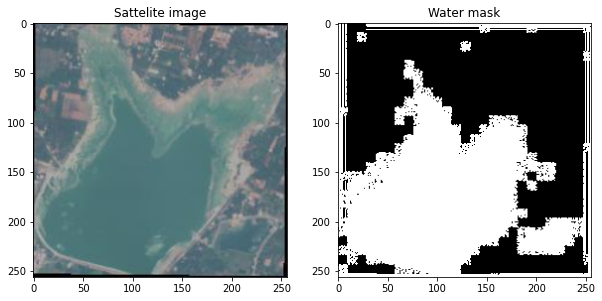

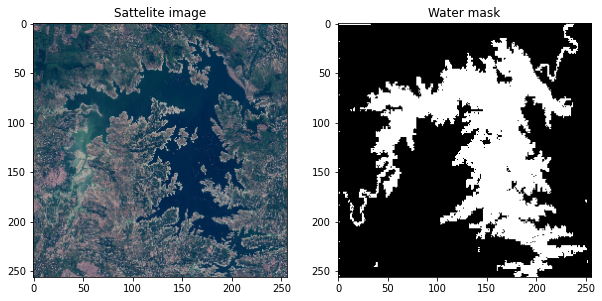

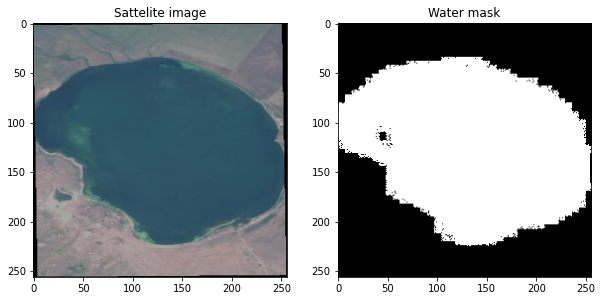

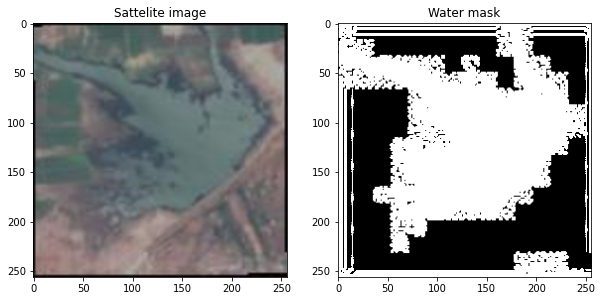

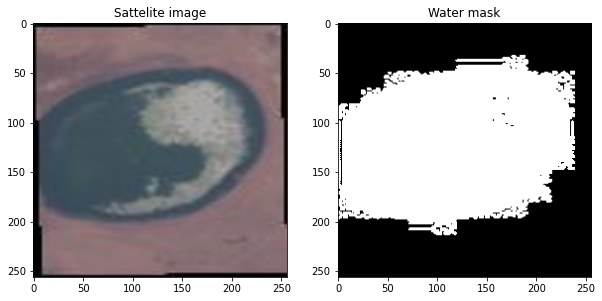

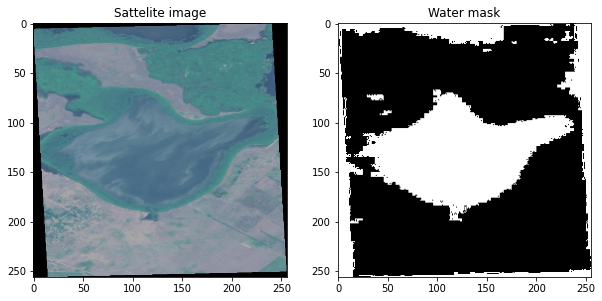

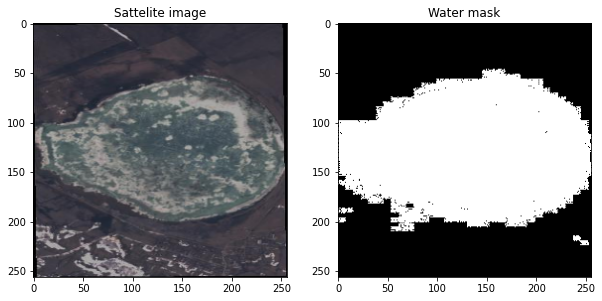

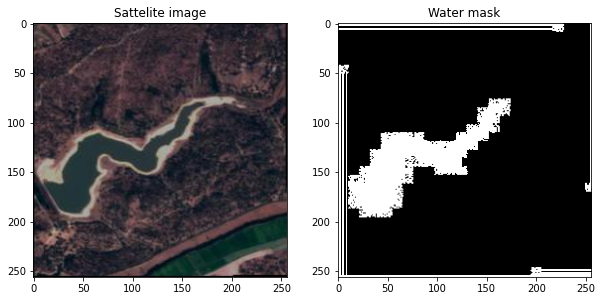

In [ ]:
for n , i in enumerate(list(np.random.randint(0,len(x_train),8))) :
  figure,ax = plt.subplots(1,2,figsize=(10,10))
  ax[0].imshow(x_train[i])
  ax[1].imshow(y_train[i], cmap='gray')
  ax[0].set_title("Sattelite image")
  ax[1].set_title("Water mask")

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [ ]:
Y_test.shape

(285, 256, 256)

In [ ]:
def unet(input_size = (256,256,3)):
    inputs = tf.keras.layers.Input(input_size)
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
UNet = unet(input_size=(256,256,3))

In [ ]:
UNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

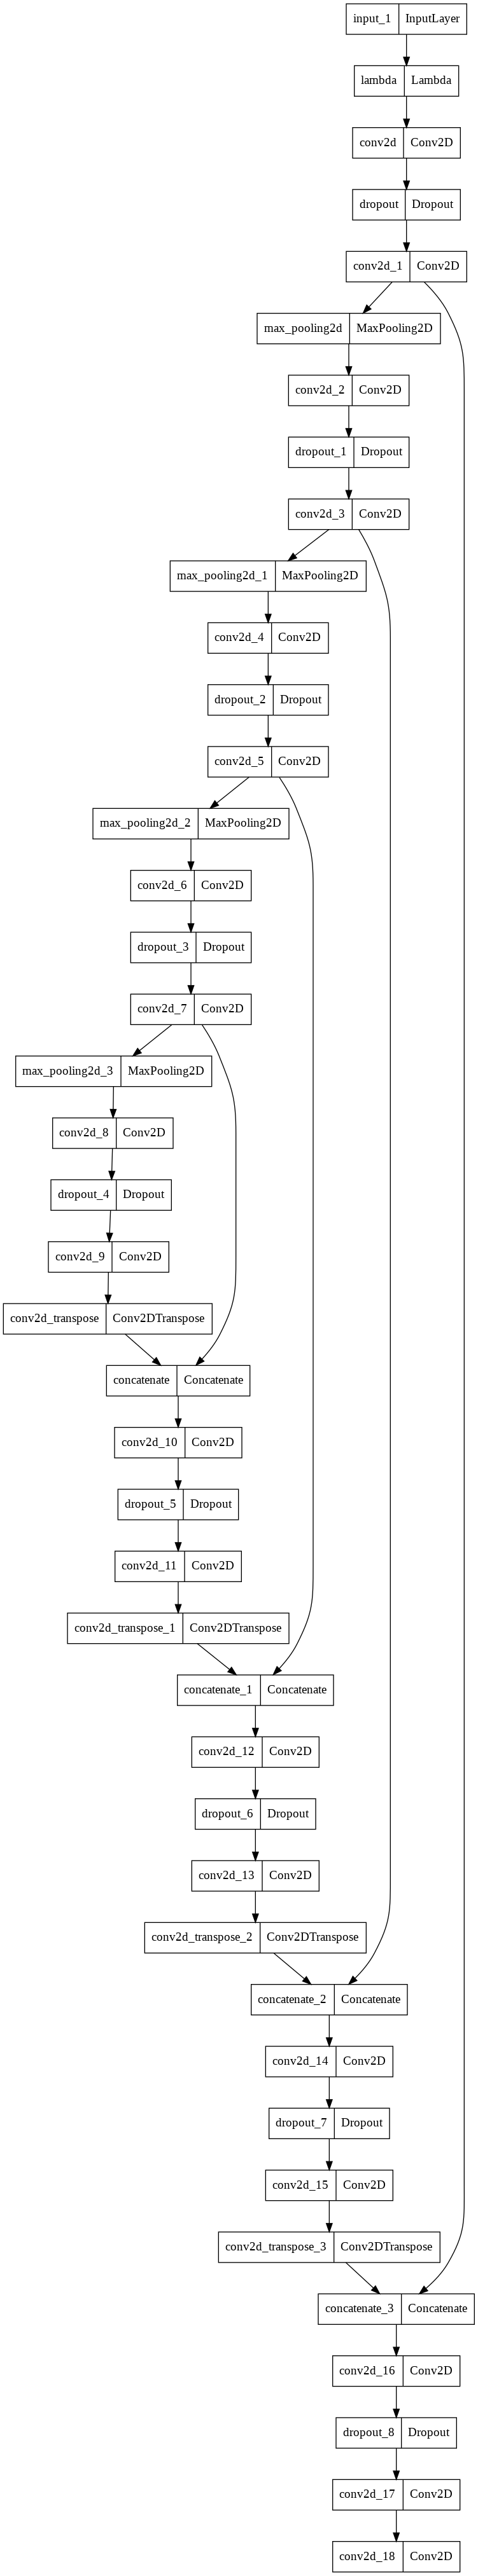

In [ ]:
plot_model(UNet,  to_file='Unet.png')

In [ ]:
optimizer_adam = Adam(learning_rate = 0.001)

In [ ]:
EarlyStop = EarlyStopping(patience = 10, restore_best_weights = True)
Reduce_LR = ReduceLROnPlateau(monitor = 'val_accuracy', verbose = 2, factor = 0.5, min_lr = 0.00001)
model_check = ModelCheckpoint('model.hdf5', monitor = 'accuracy', verbose = 1, save_best_only = True)
tensorboard = TensorBoard(log_dir = 'logs')
callback = [EarlyStop , Reduce_LR, model_check, tensorboard]

In [ ]:
UNet.compile(optimizer = optimizer_adam, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
training_history = UNet.fit(X_train, Y_train, validation_split = 0.1 , epochs = 60, batch_size = 16, callbacks = callback, verbose = 1)

Epoch 1/60
144/144 [==============================] - ETA: 0s - loss: 0.6210 - accuracy: 0.6615
Epoch 00001: accuracy improved from -inf to 0.66153, saving model to model.hdf5
144/144 [==============================] - 63s 338ms/step - loss: 0.6210 - accuracy: 0.6615 - val_loss: 0.5806 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 2/60
144/144 [==============================] - ETA: 0s - loss: 0.5773 - accuracy: 0.7058
Epoch 00002: accuracy improved from 0.66153 to 0.70581, saving model to model.hdf5
144/144 [==============================] - 46s 319ms/step - loss: 0.5773 - accuracy: 0.7058 - val_loss: 0.5607 - val_accuracy: 0.7207 - lr: 0.0010
Epoch 3/60
144/144 [==============================] - ETA: 0s - loss: 0.5570 - accuracy: 0.7143
Epoch 00003: accuracy improved from 0.70581 to 0.71426, saving model to model.hdf5
144/144 [==============================] - 46s 317ms/step - loss: 0.5570 - accuracy: 0.7143 - val_loss: 0.5306 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 4/60
144/144 [=====

In [ ]:
model = keras.models.load_model('/content/model.hdf5')

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)

9/9 [==============================] - 8s 531ms/step - loss: 0.3574 - accuracy: 0.8455


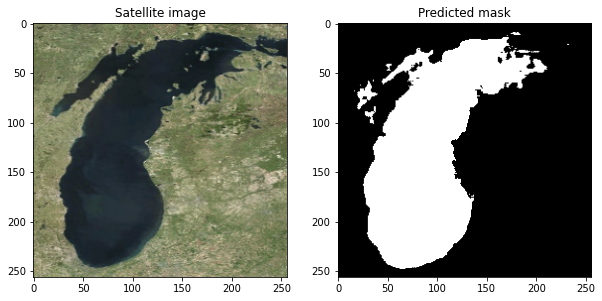

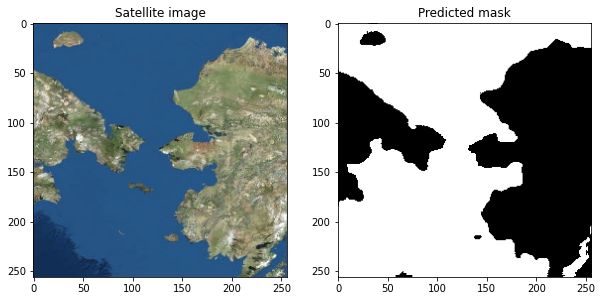

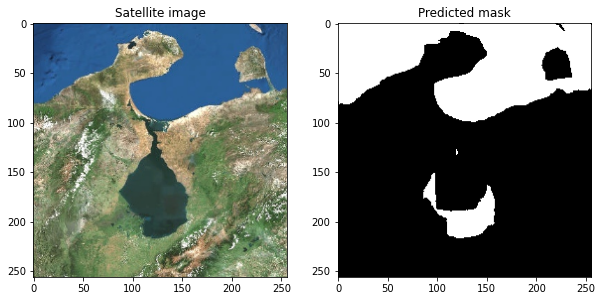

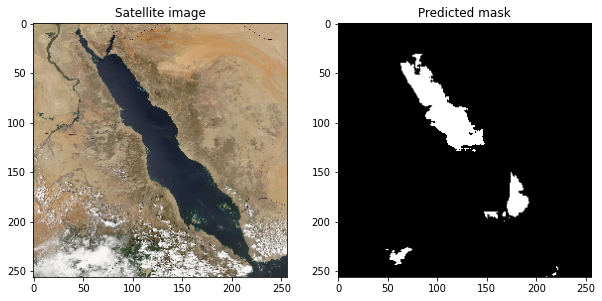

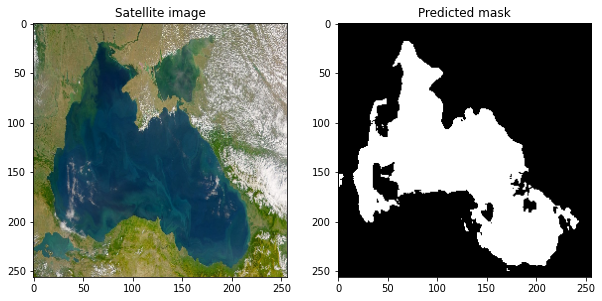

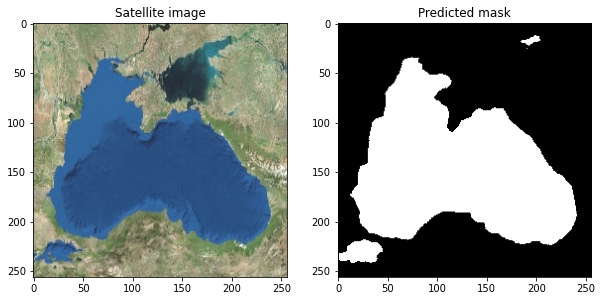

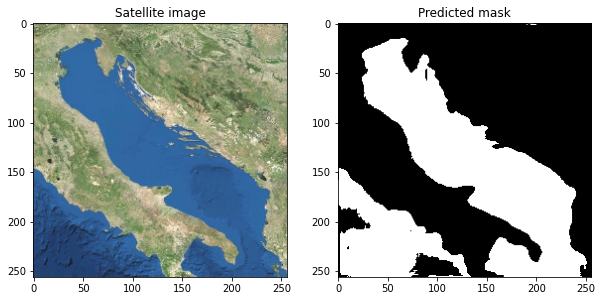

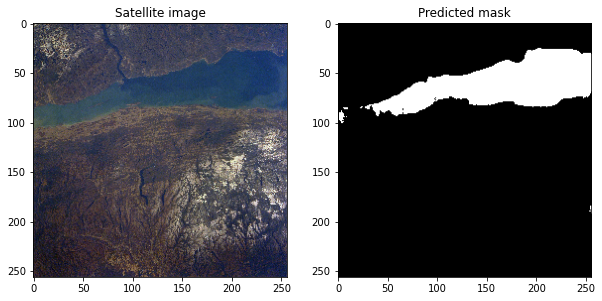

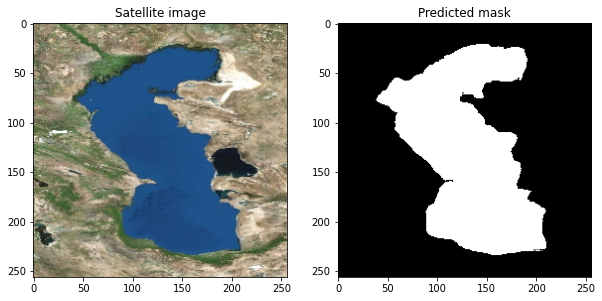

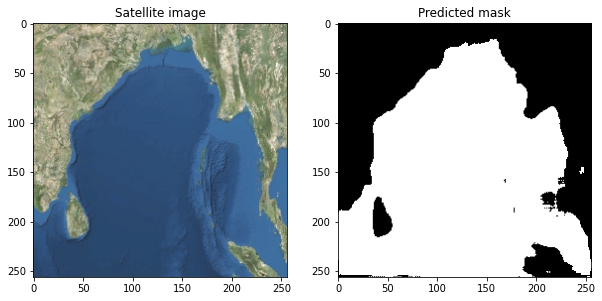

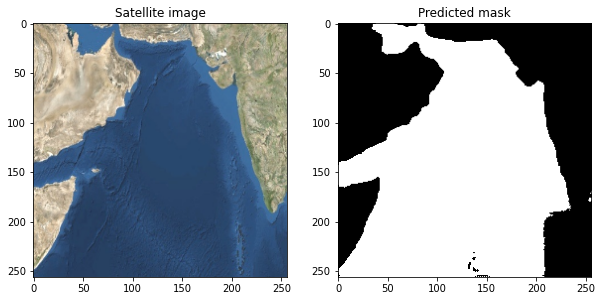

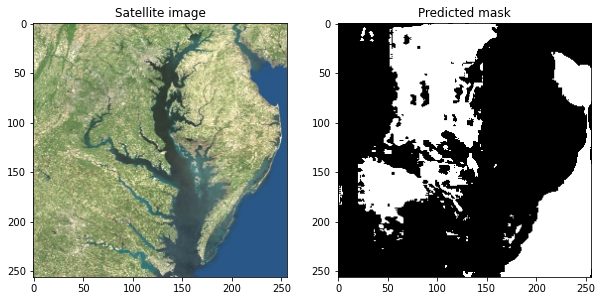

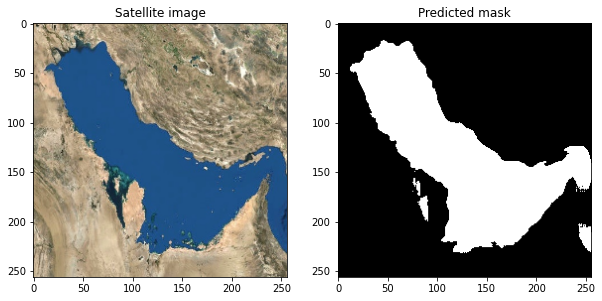

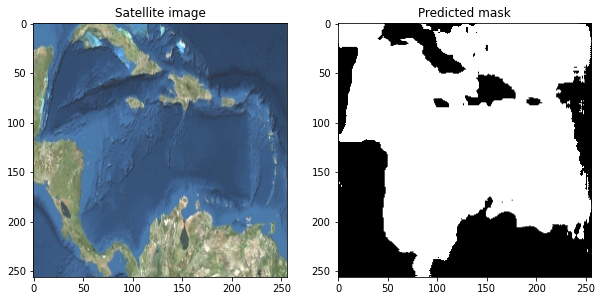

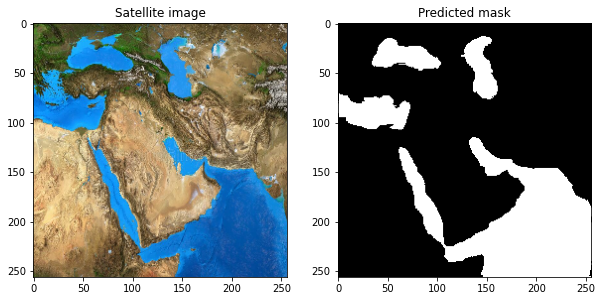

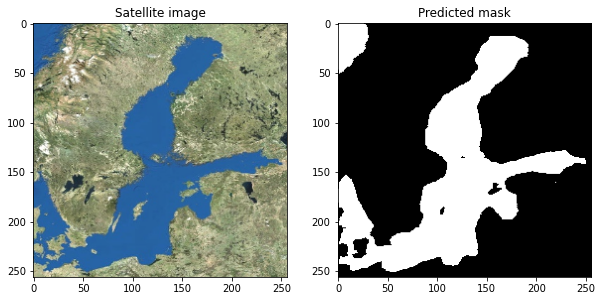

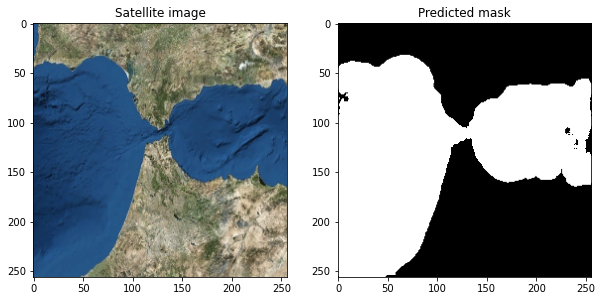

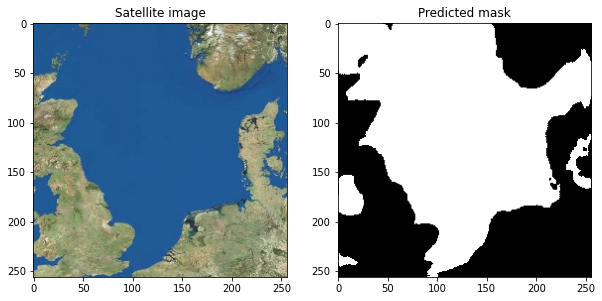

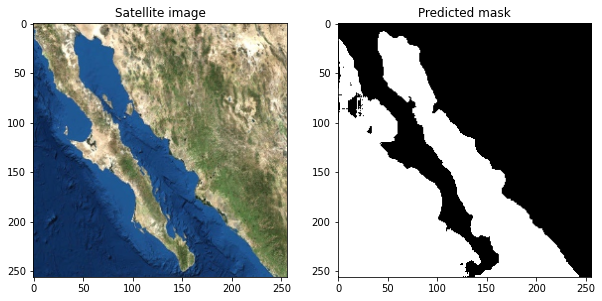

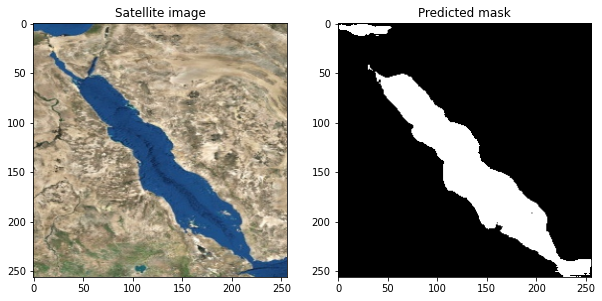

In [ ]:
test_dir = Path('/content/test')

for filename in os.listdir(test_dir):
    water_test = cv2.imread(os.path.join(test_dir,filename))
    water_test_to_RGB = cv2.cvtColor(water_test,cv2.COLOR_BGR2RGB)
    water_test_resized = cv2.resize(water_test_to_RGB,(256,256))

    water_test_for_prediction = np.expand_dims(water_test_resized, axis=0)
    y_pred = model.predict(water_test_for_prediction)

    predicted_mask = np.squeeze(y_pred)
    predicted_mask_binary = (predicted_mask > 0.75).astype(np.uint8)

    figure,ax = plt.subplots(1,2,figsize=(10,10))    
    ax[0].imshow(water_test_resized)
    ax[1].imshow(predicted_mask_binary, cmap='gray')
    ax[0].set_title("Satellite image")
    ax[1].set_title("Predicted mask")

Text(0.5, 1.0, 'Predicted mask')

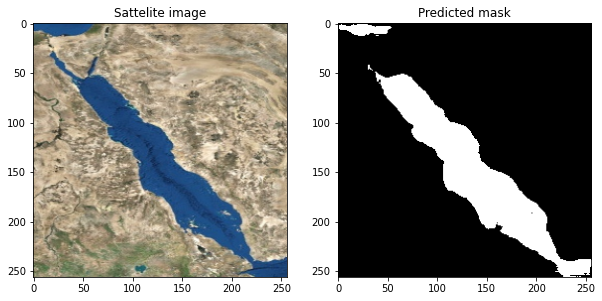

In [ ]:
figure,ax = plt.subplots(1,2,figsize=(10,10))    
ax[0].imshow(water_test_resized)
ax[1].imshow(predicted_mask_binary, cmap='gray')
ax[0].set_title("Sattelite image")
ax[1].set_title("Predicted mask")